## Google-Symptoms DAP Appendix I: Correlation Analysis

Analyst: Jingjing

Advisors: Jacob and Nat

Stackholder: Ryan and Nigam

In [82]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import re
from itertools import product
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from scipy.stats import spearmanr, rankdata
import seaborn as sns

import pandas as pd
import numpy as np

import covidcast
from delphi_utils import GeoMapper


gmpr = GeoMapper()

### Time-wise Correlation Analysis

For each of our sensorized indicators, we compute time-wise correlations over a moving window of 6 weeks wide. For each date and each county, we compute the spearman rank correlation with smoothed case incidence data from USA-Facts. Notice that for a 6-week window ending with date t, the data considered are sensored by static sensorization which is trained on data from the earliest date (2020-02-20) to date t-7. This means the data we used for different time windows have different "as of date". On the contrary,  the target we use is the smoothed confirm case incidence rates provided by USA-Facts with as of date 2020-12-14.

In the line plots below, we show the median (solid lines) and 0.25 & 0.75 quantiles (filled area) of the correlations for each across all available counties for that indicator to reduce the dimension for visualization. Notice that the list of available counties for different indicators can vary largely. 


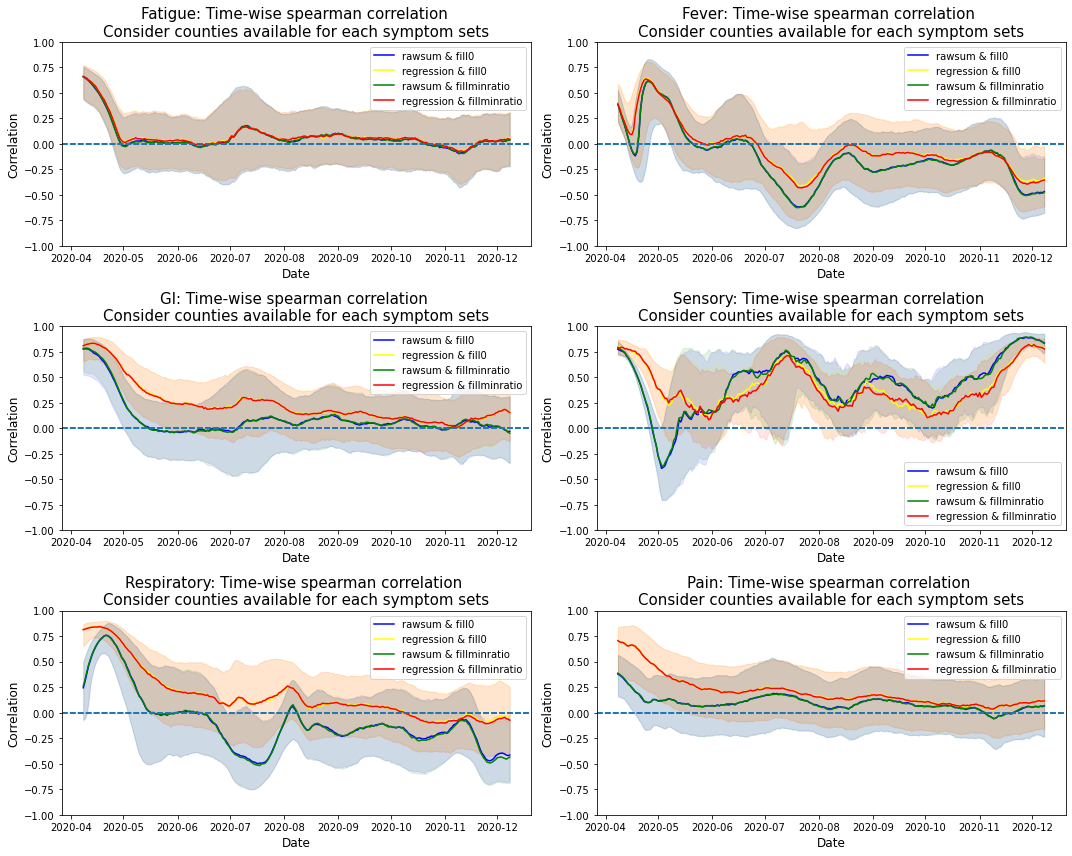

In [49]:
plt.figure(figsize = (15, 12))
i=1
color_dict = {("fill0", "rawsum"): "blue",
              ("fill0", "regression"): "yellow",
              ("fillminratio", "rawsum"): "green",
              ("fillminratio", "regression"): "red"}

signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
corr_dfs = {}
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}
                    
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of/time_wise_corr/%s_corr_df_%s_%s.csv"%(signal,
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal]["county"] = [str(x).zfill(5) for x in corr_dfs[fillmissingness][method][signal]["county"]]

            current_df = corr_dfs[fillmissingness][method][signal]
            plot_df = current_df.groupby("date")["correlation"].median().reset_index()
            plot_75_df = current_df.groupby("date")["correlation"].quantile(0.75).reset_index()
            plot_25_df = current_df.groupby("date")["correlation"].quantile(0.25).reset_index()
            plt.plot(plot_df["date"], plot_df["correlation"], label="%s & %s"%(method, fillmissingness),
                    color = color_dict[(fillmissingness, method)])
            plt.fill_between(plot_df["date"], plot_75_df["correlation"], 
                             plot_25_df["correlation"],
                             color=color_dict[(fillmissingness, method)], alpha=0.1,
                             interpolate=True)          
            plt.title("%s: Time-wise spearman correlation \nConsider counties available for each symptom sets"%signal, fontsize=15)
            plt.ylim((-1, 1))
            plt.xlabel("Date", fontsize=12)
            plt.ylabel("Correlation", fontsize=12)
            plt.axhline(0, linestyle="--")
            plt.legend()

#plt.legend(bbox_to_anchor=(0.5, -0.25))
plt.tight_layout()

In order to figure out why Sensory stands out, we stabilized the list of counties considered to be the same list with ~100 counties that are available for all the symptom sets including Sensory. The results are much different from what we can see in the plots shown above. Firstly, the lines here are more fluctuated for symptom sets except for Sensory. Secondly, we can clearly see that there are peaks around mid-July for all the lines of Fatigue, GI, Sensory, and Pain. However, there are valleys on the lines for rawsum while still peak on the lines for regression if looking at the subplots for Fever and Respiratory. A reasonable guess is that some of the symptoms in these two sets and the confirmed incidence case rates have a larger lag in time near the mid-July peak. A similar situation appeared in November and December.

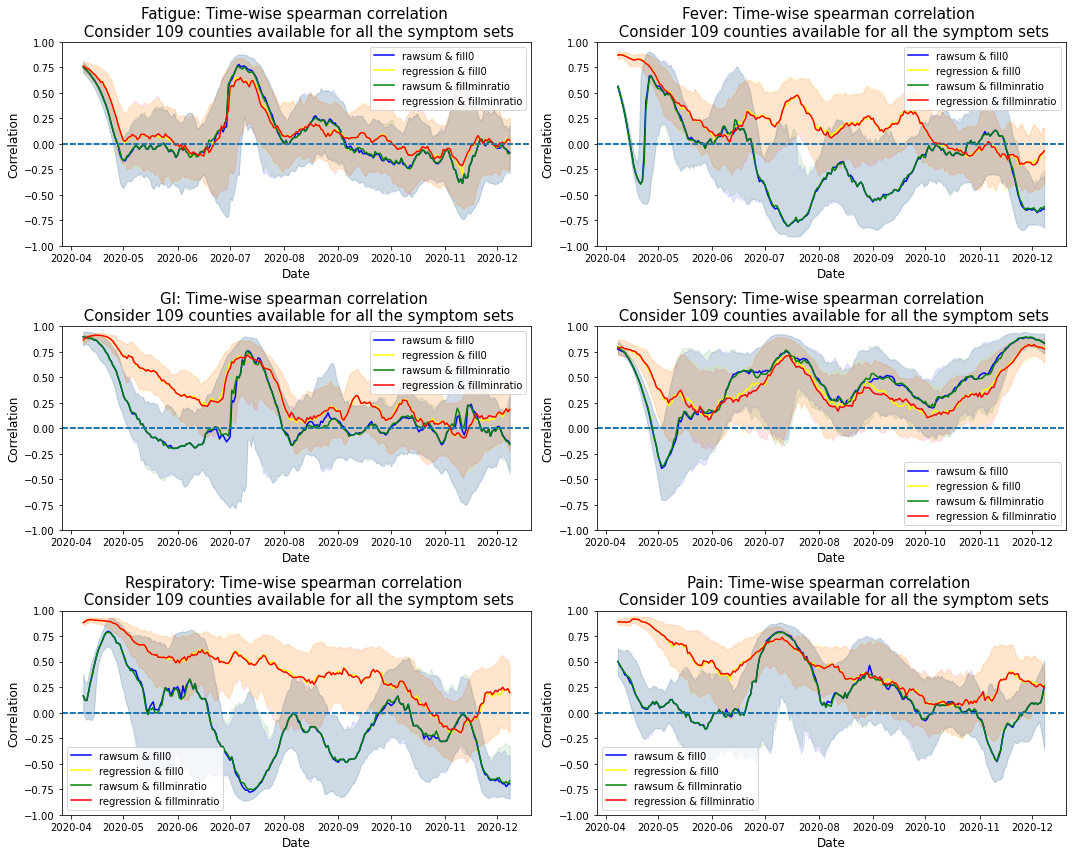

In [50]:
plt.figure(figsize = (15, 12))
i=1
corr_dfs = {}
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}
                    
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of/time_wise_corr/%s_restricted_timewise_corr_df_%s_%s.csv"%(signal,
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal]["county"] = [str(x).zfill(5) for x in corr_dfs[fillmissingness][method][signal]["county"]]

            current_df = corr_dfs[fillmissingness][method][signal]
            plot_df = current_df.groupby("date")["correlation"].median().reset_index()
            plot_75_df = current_df.groupby("date")["correlation"].quantile(0.75).reset_index()
            plot_25_df = current_df.groupby("date")["correlation"].quantile(0.25).reset_index()
            plt.plot(plot_df["date"], plot_df["correlation"], label="%s & %s"%(method, fillmissingness),
                    color = color_dict[(fillmissingness, method)])
            plt.fill_between(plot_df["date"], plot_75_df["correlation"], 
                             plot_25_df["correlation"],
                             color=color_dict[(fillmissingness, method)], alpha=0.1,
                             interpolate=True)          
            plt.title("%s: Time-wise spearman correlation \n Consider 109 counties available for all the symptom sets"%signal, fontsize=15)
            plt.ylim((-1, 1))
            plt.xlabel("Date", fontsize=12)
            plt.ylabel("Correlation", fontsize=12)
            plt.axhline(0, linestyle="--")
            plt.legend()

#plt.legend(bbox_to_anchor=(0.5, -0.25))
plt.tight_layout()

To confirm our conjecture, we drew the time series lines for smoothed google symptoms with missing values filled using fillminratio method. The lines represent the median of the scaled values across the 109 selected counties and the scaling factors are the maximum popularity of each symptom during the time period. Compared with the trend of confirmed incidence case rates, we can see Hyperthermia in Fever, Asthma, and Cough in Respiratory can obviously serve as leading indicators if considering the peak in mid-July only. Actually, nearly all the symptoms in Fever and Respiratory show advanced peaks in mid-March while the dramatic increase of case rates appears in early April.

Remember the Google symptoms values are pre-scaled according to a regionally specific population of search users and the maximum value of the normalized popularity over all symptoms. During the sensorization step, we do not make any further scaling or normalization. This means that the overall popularity of different symptoms is likely to vary largely which can be shown in the plots below. If rawsum is used to combine multiple symptoms, the indicator can be dominated by symptoms that have the largest overall popularity.

In [77]:
symptom_sets = {
    "Respiratory": ["symptom:Cough", "symptom:Phlegm", "symptom:Shortness of breath", "symptom:Wheeze",
                        "symptom:Asthma", "symptom:Pneumonia", "symptom:Sore throat"],
    "Sensory": ["symptom:Anosmia", "symptom:Dysgeusia", "symptom:Ageusia"],
    "Fever": ["symptom:Fever", "symptom:Hyperthermia", "symptom:Chills", "symptom:Shivering"],
    "Fatigue": ["symptom:Fatigue", "symptom:Weakness"],
    "GI": ["symptom:Nausea", "symptom:Vomiting", "symptom:Diarrhea", "symptom:Indigestion",
          "symptom:Abdominal pain"],
    "Pain": ["symptom:Pain", "symptom:Sharp pain", "symptom:Chest pain", "symptom:Myalgia",
             "symptom:Arthralgia", "symptom:Eye pain", "symptom:Headache", "symptom:Migraine",
             "symptom:Cramp"]
}
gs_df = pd.read_csv("./raw/county_fillminratio_smoothed_google_symptoms_12_14.csv", parse_dates=["date"])
geo_list = pd.read_csv("./sensorization_with_as_of/sensored/%s_%s_%s_sensorization_12_14.csv"%("Sensory", "regression", "fill0"), 
                     parse_dates=["date"]).dropna()["geo_id"].unique()

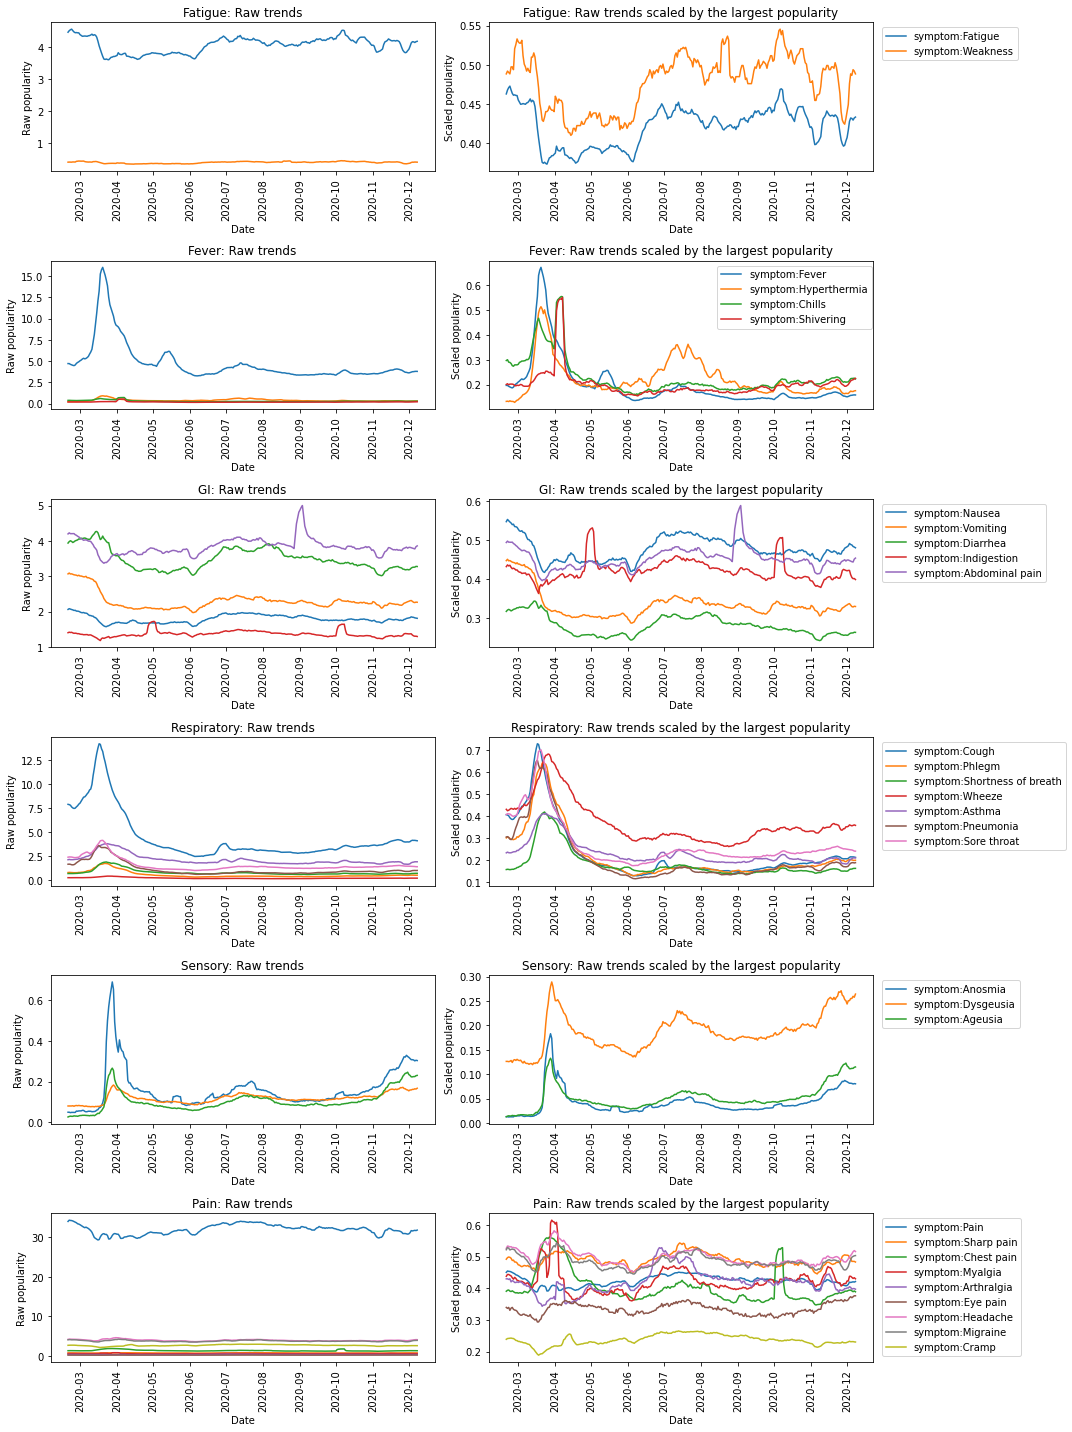

In [80]:
plt.figure(figsize = (15, 20))
i=1
median_df = gs_df.loc[gs_df["geo_id"].isin(geo_list)].groupby("date").median().reset_index()
gsmax = gs_df.max()
for setn in ["Fatigue", "Fever", "GI", "Respiratory", "Sensory", "Pain"]:
    plt.subplot(6, 2, i)
    
    for col in symptom_sets[setn]:
        plt.plot(median_df["date"], median_df[col], label=col)   
    plt.title("%s: Raw trends"%setn)
    plt.xticks(rotation=90)
    plt.xlabel("Date")
    plt.ylabel("Raw popularity")
    
    plt.subplot(6, 2, i+1)    
    for col in symptom_sets[setn]:
        plt.plot(median_df["date"], median_df[col]/gsmax[col], label=col)   
    plt.legend(bbox_to_anchor=(1.01,1))
    plt.title("%s: Raw trends scaled by the largest popularity"%setn)
    plt.xticks(rotation=90)
    plt.xlabel("Date")
    plt.ylabel("Scaled popularity")
    
    i+=2
plt.tight_layout()

### Geo-wise correlation Analysis

Remember that the raw dataset is scaled in a regionally specific manner which makes it incomparable across locations. A benefit of sensorization is that now it makes sense to consider the geo-wise correlation of the indicators based on Google-symptoms. On the plots shown below, each point of a single line represents the geo-wise correlation again the target with as of date 2020-12-14, but the data of the sensored indicator has as of date equal to the current date. For example, for the point at date t, the data we used for the Fatigue indicator is predicted by linear regression models trained on data from the earliest date 2020-02-20 to date t-7 for each county. Again, the lists of locations considered when calculating the geo-wise correlation for different indicators are different for different symptom sets.

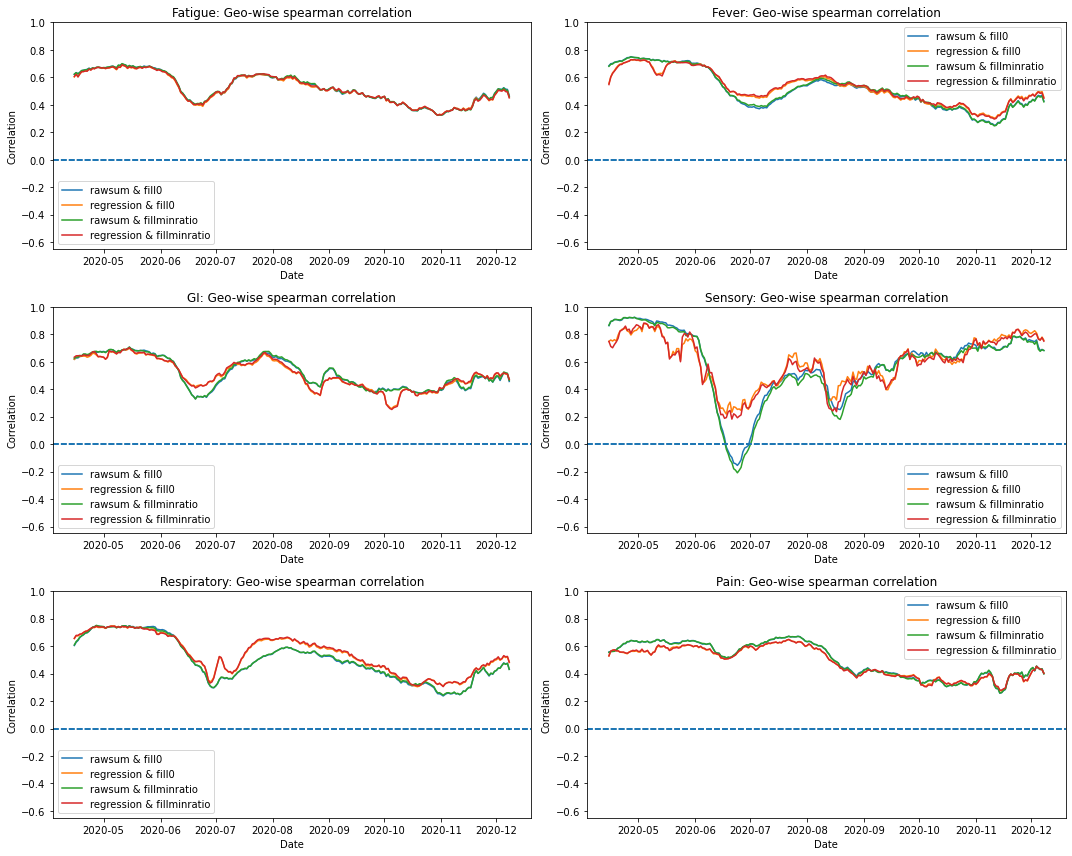

In [4]:
plt.figure(figsize = (15, 12))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}        
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of/geo_wise_varying_as_of/%s_static_geowise_corr_df_%s_%s.csv"%(signal.lower(),
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal] = corr_dfs[fillmissingness][method][signal].loc[
                corr_dfs[fillmissingness][method][signal]["date"] >= datetime(2020, 4, 15)
            ]
        
            current_df = corr_dfs[fillmissingness][method][signal]
            plt.plot(current_df["date"], current_df["correlation"], label="%s & %s"%(method, fillmissingness))
            plt.title("%s: Geo-wise spearman correlation"%signal)
            plt.ylim((-0.65, 1))
            plt.xlabel("Date")
            plt.ylabel("Correlation")
            plt.axhline(0, linestyle="--")
            plt.legend()
plt.tight_layout()

Similarly, now we only consider the 109 counties that are available for all the symptom sets. The number of counties under consideration was greatly reduced, resulting in stronger volatility in the original curve. At the same time, the difference between rawsum and regression is also magnified. There are deeper and wider valleys from June to August on the lines for regression comparing with those for rawsum. 

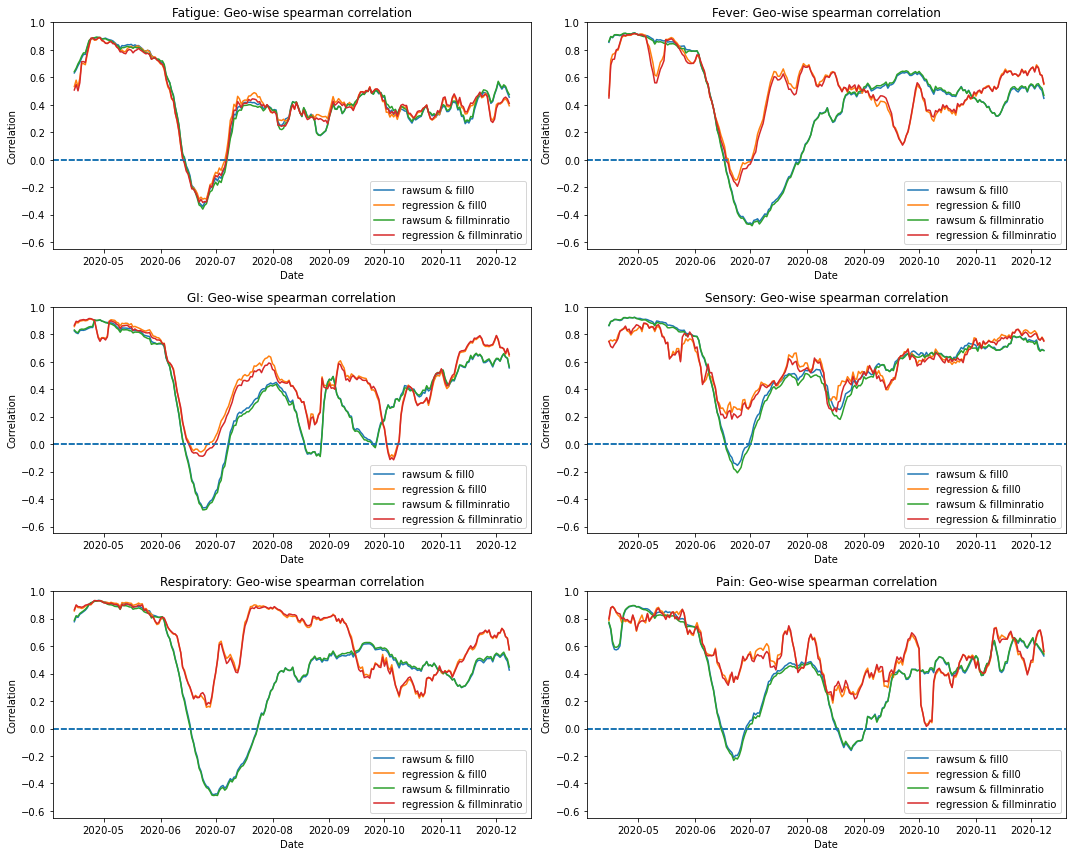

In [6]:
plt.figure(figsize = (15, 12))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}        
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of/geo_wise_varying_as_of/%s_restricted_static_geowise_corr_df_%s_%s.csv"%(signal.lower(),
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal] = corr_dfs[fillmissingness][method][signal].loc[
                corr_dfs[fillmissingness][method][signal]["date"] >= datetime(2020, 4, 15)
            ]
        
            current_df = corr_dfs[fillmissingness][method][signal]
            plt.plot(current_df["date"], current_df["correlation"], label="%s & %s"%(method, fillmissingness))
            plt.title("%s: Geo-wise spearman correlation"%signal)
            plt.ylim((-0.65, 1))
            plt.xlabel("Date")
            plt.ylabel("Correlation")
            plt.axhline(0, linestyle="--")
            plt.legend()
plt.tight_layout()

Here we draw the popularity trends for symptoms in cluster "Fever" for 109 counties that are shared by all the symptom sets. We can see from the plots below, spatial heterogeneity exists among locations for nearly all the symptoms. It’s very interesting that although the first peak of all symptom popularity almost falls on late March, their peaks around July are shifted from each other, which can be an important cause of negative correlations. 

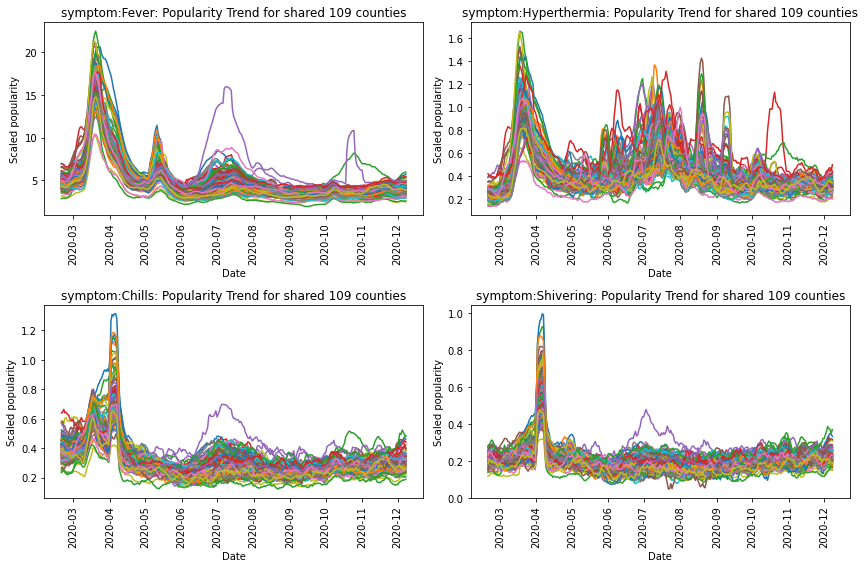

In [81]:
plt.figure(figsize=(12, 8))
i = 1
for sym in symptom_sets["Fever"]:
    plt.subplot(2, 2, i)
    i += 1
    for loc in geo_list:
        subdf = gs_df.loc[gs_df["geo_id"] == loc]
        plt.plot(subdf["date"], subdf[sym])
    plt.xlabel("Date")
    plt.ylabel("Scaled popularity")
    plt.title("%s: Popularity Trend for shared 109 counties"%sym)
    plt.xticks(rotation=90)
plt.tight_layout()

Both time-wise correlation and geo-wise correlation are influenced by the lag in time between users' search behavior and the confirmation of cases. The difference in overall popularity between different symptoms will dramatically magnify or reduce the impact of lag in time in the sensored indicators. Considering the two methods to combine multiple symptoms, regression outperforms rawsum in two aspects:
- avoid indicators being dominated by some of the symptoms with large overall popularity
- preliminarily consider the impact of lag in time by adjusting the weight of different symptoms in the combinations and the signs of the coefficients




### Sanity Check: Scatter plot for sensored indicators v.s. confirmed case incidence rates

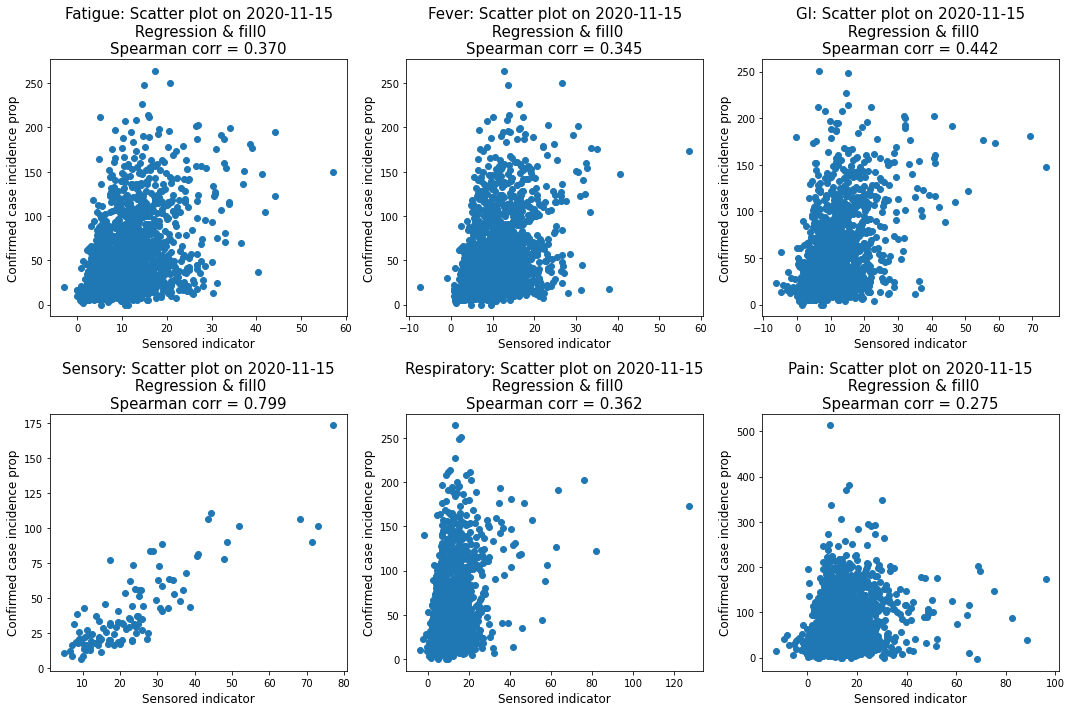

In [52]:
_d = datetime(2020, 11, 15)
method = "regression"
fillmissingness = "fill0"
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]

plt.figure(figsize = (15, 10))
i = 1
for setn in signal_list:
    plt.subplot(2, 3, i)
    i+=1
    df = pd.read_csv("./sensorization_with_as_of/sensored/%s_%s_%s_sensorization_12_14.csv"%(setn, method, fillmissingness), 
                     parse_dates=["date"]).dropna()
    df = df.loc[df["date"] == _d]
    corr = spearmanr(df[["predicted", "cases"]].values,
                              nan_policy="omit")[0]
    plt.title("%s: Scatter plot on 2020-11-15\n Regression & fill0\nSpearman corr = %.3f"%(setn, corr), fontsize=15)
    plt.scatter(df["predicted"], df["cases"])
    plt.xlabel("Sensored indicator", fontsize=12)
    plt.ylabel("Confirmed case incidence prop", fontsize=12)
plt.tight_layout()

### Geo-wise correlation using data where as_of = 2020-12-08 for all the points

Data points on a single line have the same as of date. Here we computed the geo-wise correlation using data sensored by models training on all the data on/before 2020-12-01. The same, the methods for filling missingness do not matter much. All the symptom sets except for Sensory show downwards U-shape lines. Compared with the geo-wise correlation plots shown above, as more date available for training, static sensorization will lose the accuracy of early point correction.

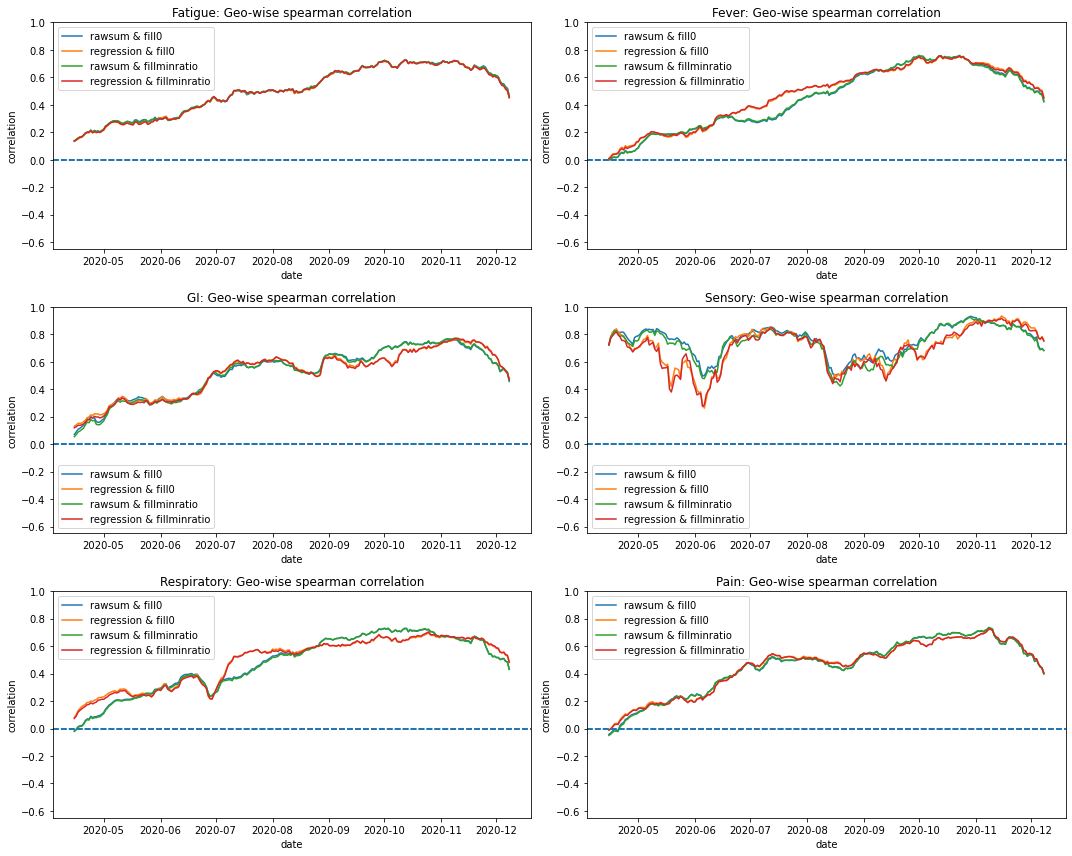

In [11]:
plt.figure(figsize = (15, 12))
i=1
signal_list = ["Fatigue", "Fever", "GI", "Sensory", "Respiratory", "Pain"]
for signal in signal_list:
    plt.subplot(3, 2, i)
    i+=1
    for fillmissingness in ["fill0", "fillminratio"]:
        corr_dfs[fillmissingness] = {}
        for method in ["rawsum", "regression"]:
            corr_dfs[fillmissingness][method] = {}        
            corr_dfs[fillmissingness][method][signal] = pd.read_csv("./sensorization_with_as_of/geo_wise_final_as_of/%s_static_geowise_corr_df_%s_%s.csv"%(signal.lower(),
                                                                                            method,
                                                                                            fillmissingness),
                                                                   parse_dates=["date"]) 
            corr_dfs[fillmissingness][method][signal] = corr_dfs[fillmissingness][method][signal].loc[
                corr_dfs[fillmissingness][method][signal]["date"] >= datetime(2020, 4, 15)
            ]
        
            current_df = corr_dfs[fillmissingness][method][signal]
            plt.plot(current_df["date"], current_df["correlation"], label="%s & %s"%(method, fillmissingness))
            plt.title("%s: Geo-wise spearman correlation"%signal)
            plt.ylim((-0.65, 1))
            plt.xlabel("date")
            plt.ylabel("correlation")
            plt.axhline(0, linestyle="--")
            plt.legend()
plt.tight_layout()